In [1]:
import tensorflow as tf
import numpy as np
from our_env import OurEnv
from collections import deque
from tqdm.notebook import trange
import matplotlib.pyplot as plt
import pylab as pl
from IPython import display

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
env = OurEnv((-.5, -5))
reset_args = {
    "seed": 42,
    "options": {
        "low": -np.pi / 2,
        "high": np.pi / 2
    },
}
observation, info = env.reset(**reset_args)

input_shape = env.observation_space.shape
n_outputs = env.action_space.n
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 1,381
Trainable params: 1,381
Non-trainable params: 0
_________________________________________________________________


In [3]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)
        return np.argmax(Q_values[0])

In [4]:
replay_buffer = deque(maxlen=2000)

In [5]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [6]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, _, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [7]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1 - dones) * discount_factor * max_next_Q_values)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

  0%|          | 0/1800 [00:00<?, ?it/s]

down|

2022-11-18 19:22:04.266221: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


down|down|up|down|down|up|down|down|up|down|up|down|down|down|down|up|down|


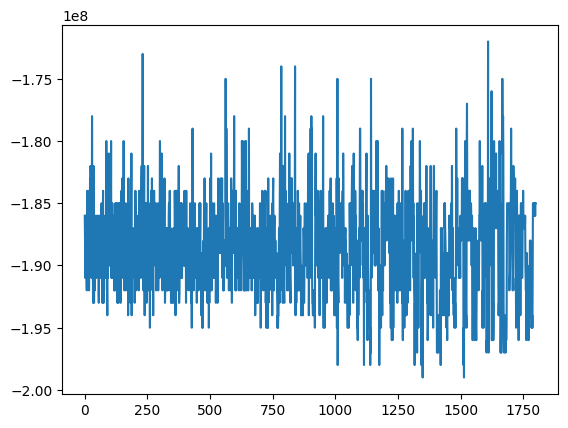

In [8]:
reward_sum_per_episode = []
n_episodes = 1800

last100 = 0
for episode in trange(n_episodes):
    reward_sum = 0
    obs, _ = env.reset(**reset_args)
    for step in range(200):
        epsilon = max(1 - episode / (.9*n_episodes), 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        reward_sum += reward
        if done:
            break
    reward_sum_per_episode.append(reward_sum)
    if episode > (.1*n_episodes):
        training_step(batch_size)
    if episode % 100 == 0:
        prevlast100 = last100
        last100 = np.mean(reward_sum_per_episode[-100:])
        print("down" if last100 < prevlast100 else "up", end="|")
print()
plt.plot(reward_sum_per_episode)

In [9]:
model.save('models/model2.h5')